# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.5012541803539059
 0.9933609203401452
 0.3944893180676192
 0.2446035212262776
 0.8143940529013705
 0.032887372314962526
 0.8262733282856822
 0.3912114710559349
 0.43529567366601785
 0.1542058799204118
 0.05746977526966601
 0.18317127845215508
 0.6431322872083249
 ⋮
 0.4063528564437253
 0.026866494828949206
 0.9339921977019192
 0.310028849252449
 0.739042234752626
 0.1699746236340145
 0.9504883470305974
 0.7248007274709465
 0.36192938797492036
 0.7400797699007593
 0.6721029424239575
 0.06318143950068444

In [2]:
sum(a)

5.001596529905331e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.005433 seconds (1 allocation: 16 bytes)


5.001596529905331e6

In [4]:
@time sum(a)

  0.006755 seconds (1 allocation: 16 bytes)


5.001596529905331e6

In [5]:
@time sum(a)

  0.005820 seconds (1 allocation: 16 bytes)


5.001596529905331e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [ ]:
using Pkg
Pkg.add("BenchmarkTools")

In [7]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [8]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [9]:
c_sum(a)

5.001596529905427e6

In [10]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [11]:
c_sum(a) - sum(a)  

9.592622518539429e-8

In [12]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [13]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.


We can now benchmark the C code directly from Julia:

In [ ]:
c_bench = @benchmark c_sum($a)

In [15]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 11.610195 msec


In [16]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 11.6102

In [17]:
using Plots
gr()

Plots.GRBackend()

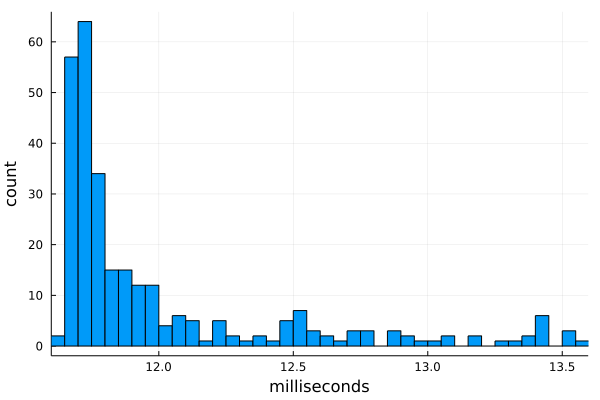

In [18]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [19]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [20]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 851 samples with 1 evaluation.
 Range (min … max):  4.377 ms … 31.716 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.033 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.852 ms ±  1.969 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                           
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁▁▁▁▁▁ ▁
  5.11 ms        Histogram: frequency by time        4.65 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [21]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

4.377002

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [ ]:
using Pkg; Pkg.add("PyCall")
using PyCall

In [23]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [24]:
pysum(a)

5.001596529905427e6

In [25]:
pysum(a) ≈ sum(a)

true

In [26]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  724.151 ms … 900.215 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     808.521 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   801.504 ms ±  75.186 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █        █                                                     
  █▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁
  724 ms           Histogram: frequency by time          731 ms <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [27]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 11.6102
  "Python built-in" => 724.151
  "C -ffast-math"   => 4.377

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [ ]:
using Pkg; Pkg.add("Conda")
using Conda

In [ ]:
Conda.add("numpy")

In [30]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 1017 samples with 1 evaluation.
 Range (min … max):  4.204 ms … 32.455 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.622 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.903 ms ±  1.281 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                           
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁▁ ▁▁ ▁
  5.35 ms        Histogram: frequency by time        4.55 ms <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [31]:
numpy_sum(a)

5.001596529905329e6

In [32]:
numpy_sum(a) ≈ sum(a)

true

In [33]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 11.6102
  "Python numpy"    => 4.20387
  "Python built-in" => 724.151
  "C -ffast-math"   => 4.377

# 5. Python, hand-written 

In [34]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7fd4872084c0>

In [35]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  941.357 ms … 995.683 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     969.960 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   968.470 ms ±  23.532 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

                                                                 
  ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁
  992 ms           Histogram: frequency by time          965 ms <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [36]:
sum_py(a)

5.001596529905427e6

In [37]:
sum_py(a) ≈ sum(a)

true

In [38]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 11.6102
  "Python numpy"        => 4.20387
  "Python hand-written" => 941.357
  "Python built-in"     => 724.151
  "C -ffast-math"       => 4.377

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [39]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:873

In [40]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 1048 samples with 1 evaluation.
 Range (min … max):  4.170 ms …   9.967 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.419 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.752 ms ± 900.697 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                            
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁
  5 ms            Histogram: frequency by time         4.4 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [41]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 11.6102
  "Python numpy"        => 4.20387
  "Python hand-written" => 941.357
  "Python built-in"     => 724.151
  "Julia built-in"      => 4.17017
  "C -ffast-math"       => 4.377

# 7. Julia (hand-written) 

In [42]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [ ]:
j_bench_hand = @benchmark mysum($a)

In [44]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 11.6102
  "Python numpy"        => 4.20387
  "Julia hand-written"  => 11.8939
  "Python hand-written" => 941.357
  "Python built-in"     => 724.151
  "Julia built-in"      => 4.17017
  "C -ffast-math"       => 4.377

# 8. Julia (hand-written w. simd) 

In [53]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        @inbounds s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [54]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 1047 samples with 1 evaluation.
 Range (min … max):  4.086 ms …   9.585 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.594 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.757 ms ± 613.184 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                            
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  4.96 ms         Histogram: frequency by time        4.93 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [47]:
mysum_simd(a)

5.0015965299053285e6

In [55]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 4.08637
  "C"                       => 11.6102
  "Python numpy"            => 4.20387
  "Julia hand-written"      => 11.8939
  "Python hand-written"     => 941.357
  "Python built-in"         => 724.151
  "Julia built-in"          => 4.17017
  "C -ffast-math"           => 4.377

# Summary

In [49]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=4), 10, "."))
end

Julia hand-written simd.......4.076
Julia built-in...............4.1702
Python numpy.................4.2039
C -ffast-math.................4.377
C...........................11.6102
Julia hand-written..........11.8939
Python built-in............724.1514
Python hand-written........941.3575


In [57]:
α = 3
∇f(u) = α*u; ∇f(2)

6

In [58]:
@code_llvm 2*5


;  @ int.jl:88 within `*'
define i64 @"julia_*_7137"(i64 signext %0, i64 signext %1) {
top:
  %2 = mul i64 %1, %0
  ret i64 %2
}


In [59]:
2^-5

0.03125

In [60]:
2^5


32

In [61]:
2^-5

0.03125

In [63]:
@which 2^-5

^(x::T, p::T) where T<:Integer in Base at intfuncs.jl:290

In [64]:
function sumofsins1(n::Integer)
    r = 0
    for i in 1:n
        r += sin(3.4)
    end
    return r
end

sumofsins1 (generic function with 1 method)

In [65]:
100_00

10000

In [66]:
sumofsins1(100_000)  


-25554.110202663698

In [67]:
function sumofsins2(n::Integer)
    r = 0.0
    for i in 1:n
        r += sin(3.4)
    end
    return r
end

sumofsins2 (generic function with 1 method)

In [68]:
sumofsins2(100_000)  


-25554.110202663698

In [69]:
@time [sumofsins1(100_000) for i in 1:100];  


  0.402020 seconds (114.72 k allocations: 7.148 MiB, 67.37% gc time, 93.23% compilation time)


In [70]:
@time [sumofsins2(100_000) for i in 1:100];  


  0.107550 seconds (110.03 k allocations: 6.921 MiB, 74.05% compilation time)


In [71]:
@time [sumofsins2(100_000) for i in 1:100];  


  0.077988 seconds (110.03 k allocations: 6.921 MiB, 83.72% compilation time)


In [72]:
@time [sumofsins2(100_000) for i in 1:100];  


  0.075641 seconds (110.03 k allocations: 6.921 MiB, 83.47% compilation time)


In [73]:
@time [sumofsins2(100_000) for i in 1:100];  


  0.075624 seconds (110.03 k allocations: 6.921 MiB, 83.07% compilation time)


In [74]:
@time [sumofsins1(100_000) for i in 1:100];  


  0.085725 seconds (114.69 k allocations: 7.146 MiB, 70.72% compilation time)


In [75]:
@time [sumofsins1(100_000) for i in 1:100];  


  0.084017 seconds (114.69 k allocations: 7.146 MiB, 70.01% compilation time)


In [80]:
@code_llvm(sumofsins1(100))


;  @ In[64]:1 within `sumofsins1'
define { {}*, i8 } @julia_sumofsins1_7314([8 x i8]* noalias nocapture align 8 dereferenceable(8) %0, i64 signext %1) {
top:
;  @ In[64]:3 within `sumofsins1'
; ┌ @ range.jl:5 within `Colon'
; │┌ @ range.jl:287 within `UnitRange'
; ││┌ @ range.jl:292 within `unitrange_last'
     %.inv = icmp sgt i64 %1, 0
     %2 = select i1 %.inv, i64 %1, i64 0
; └└└
  br i1 %.inv, label %L11, label %union_move8

L11:                                              ; preds = %L49, %top
; ┌ @ range.jl:670 within `iterate'
   %.sroa.014.0 = phi i64 [ %8, %L49 ], [ 0, %top ]
   %value_phi2 = phi i64 [ %7, %L49 ], [ 1, %top ]
   %3 = phi i1 [ false, %L49 ], [ true, %top ]
   %4 = phi i1 [ true, %L49 ], [ false, %top ]
; └
;  @ In[64]:4 within `sumofsins1'
  br i1 %3, label %L31, label %L28

L28:                                              ; preds = %L11
; ┌ @ float.jl:326 within `+'
   %5 = bitcast i64 %.sroa.014.0 to double
; └
;  @ In[64]:3 within `sumofsins1'
; ┌ @ range.

In [81]:
@code_llvm(sumofsins2(100))


;  @ In[67]:1 within `sumofsins2'
define double @julia_sumofsins2_7316(i64 signext %0) {
top:
;  @ In[67]:3 within `sumofsins2'
; ┌ @ range.jl:5 within `Colon'
; │┌ @ range.jl:287 within `UnitRange'
; ││┌ @ range.jl:292 within `unitrange_last'
     %.inv = icmp sgt i64 %0, 0
     %1 = select i1 %.inv, i64 %0, i64 0
; └└└
  br i1 %.inv, label %L11, label %L37

L11:                                              ; preds = %L11, %top
  %value_phi2 = phi i64 [ %3, %L11 ], [ 1, %top ]
  %value_phi3 = phi double [ %2, %L11 ], [ 0.000000e+00, %top ]
;  @ In[67]:4 within `sumofsins2'
; ┌ @ float.jl:326 within `+'
   %2 = fadd double %value_phi3, 0xBFD05AC910FF4C6C
; └
; ┌ @ range.jl:674 within `iterate'
; │┌ @ promotion.jl:410 within `=='
    %.not.not = icmp eq i64 %value_phi2, %1
; │└
   %3 = add nuw i64 %value_phi2, 1
; └
  br i1 %.not.not, label %L37, label %L11

L37:                                              ; preds = %L11, %top
  %value_phi6 = phi double [ 0.000000e+00, %top ], [ %2, %L